In [1]:
import os
from glob import glob
import numpy as np
import dask
import xarray as xr
import cartopy.crs as ccrs
import seawater as sw
import gsw
import xgcm
from xgcm.autogenerate import generate_grid_ds
from cmocean import cm

from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/utils.py:137: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  RuntimeWarning,


In [2]:
from dask_jobqueue import PBSCluster
cluster = PBSCluster()
#print(cluster.job_script())
#print(cluster.job_header)
w = cluster.scale(28*3)

In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [40]:
client

Client Scheduler: tcp://10.148.1.2:52946 Dashboard: http://10.148.1.2:8787/status,Cluster Workers: 84 Cores: 168 Memory: 719.88 GB


_________
# 1. Read dataset


In [6]:
out_dir_work = '/home1/datawork/xyu/OSMOSIS_llc4320/data_rechunk/'
out_dir_scratch = '/home1/scratch/xyu/OSMOSIS_llc4320/data_rechunk/'

grid = xr.open_dataset(out_dir_work+'Grid.nc', decode_coords=True)
ds_U = xr.open_zarr(out_dir_scratch+'U_total_rechunk.zarr')
ds_V = xr.open_zarr(out_dir_scratch+'V_total_rechunk.zarr')
ds_W = xr.open_zarr(out_dir_scratch+'W_total_rechunk.zarr')
ds_D = xr.open_zarr(out_dir_scratch+'Pden_total_rechunk.zarr')
ds_MLD = xr.open_zarr(out_dir_work+'mld_filter.zarr')

# buoyancy
ds_B = -9.81*(ds_D.Pden-25)/1025
ds_B = np.real(ds_B).rename('Buoy')
ds_B = ds_B.to_dataset()

ds = xr.merge([ds_U,ds_V,ds_W,ds_B,ds_D,ds_MLD,grid])
ds = generate_grid_ds(ds, {'Z':'depth'})
print(ds)

<xarray.Dataset>
Dimensions:     (depth: 52, depth_left: 52, lat: 201, lat_g: 201, lon: 177, lon_g: 177, time: 9415)
Coordinates:
  * lat         (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon_g       (lon_g) float64 -18.04 -18.02 -18.0 ... -14.42 -14.4 -14.38
  * depth       (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * time        (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
  * lat_g       (lat_g) float64 47.4 47.41 47.42 47.44 ... 49.96 49.97 49.98
  * lon         (lon) float64 -18.03 -18.01 -17.99 ... -14.41 -14.39 -14.36
    XC          (lat, lon) float32 ...
    YC          (lat, lon) float32 ...
    XG          (lat_g, lon_g) float32 ...
    YG          (lat_g, lon_g) float32 ...
    CS          (lat, lon) float32 ...
    SN          (lat, lon) float32 ...
    Depth       (lat, lon) float32 ...
    dxC         (lat, lon_g) float32 ...
    dyC         (lat_g, lon) float32 ...
    dxG         (lat_g, lon) float32 .

In [7]:
gridx = xgcm.Grid(ds, coords={'X':{'center':'lon', 'left':'lon_g'},
                              'Y':{'center':'lat', 'left':'lat_g'},
                              'Z':{'center':'depth', 'left':'depth_left'}}, periodic=['X', 'Y'])
print(gridx)

<xgcm.Grid>
X Axis (periodic):
  * center   lon --> left
  * left     lon_g --> center
Y Axis (periodic):
  * center   lat --> left
  * left     lat_g --> center
Z Axis (not periodic):
  * center   depth --> left
  * left     depth_left --> center


In [8]:
# Calculate vertical distances located on the cellboundary
ds.coords['dzc'] = gridx.diff(ds.depth, 'Z', boundary='extrapolate')
# Calculate vertical distances located on the cellcenter
ds.coords['dzt'] = gridx.diff(ds.depth_left, 'Z', boundary='extrapolate')
ds

<xarray.Dataset>
Dimensions:     (depth: 52, depth_left: 52, lat: 201, lat_g: 201, lon: 177, lon_g: 177, time: 9415)
Coordinates:
  * lat         (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon_g       (lon_g) float64 -18.04 -18.02 -18.0 ... -14.42 -14.4 -14.38
  * depth       (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * time        (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
  * lat_g       (lat_g) float64 47.4 47.41 47.42 47.44 ... 49.96 49.97 49.98
  * lon         (lon) float64 -18.03 -18.01 -17.99 ... -14.41 -14.39 -14.36
    XC          (lat, lon) float32 ...
    YC          (lat, lon) float32 ...
    XG          (lat_g, lon_g) float32 ...
    YG          (lat_g, lon_g) float32 ...
    CS          (lat, lon) float32 ...
    SN          (lat, lon) float32 ...
    Depth       (lat, lon) float32 ...
    dxC         (lat, lon_g) float32 ...
    dyC         (lat_g, lon) float32 ...
    dxG         (lat_g, lon) float32 .

In [9]:
lat = ds['YG']
omega = 7.3/100000
f = 2*omega*np.sin(np.deg2rad(lat))
f_i = gridx.interp(f,'X')
f_j = gridx.interp(f,'Y')
f_ij = gridx.interp(f_i,'Y')
f

<xarray.DataArray 'YG' (lat_g: 201, lon_g: 177)>
array([[0.00010747, 0.00010747, 0.00010747, ..., 0.00010747, 0.00010747,
        0.00010747],
       [0.00010749, 0.00010749, 0.00010749, ..., 0.00010749, 0.00010749,
        0.00010749],
       [0.00010751, 0.00010751, 0.00010751, ..., 0.00010751, 0.00010751,
        0.00010751],
       ...,
       [0.00011177, 0.00011177, 0.00011177, ..., 0.00011177, 0.00011177,
        0.00011177],
       [0.00011179, 0.00011179, 0.00011179, ..., 0.00011179, 0.00011179,
        0.00011179],
       [0.00011181, 0.00011181, 0.00011181, ..., 0.00011181, 0.00011181,
        0.00011181]], dtype=float32)
Coordinates:
  * lon_g    (lon_g) float64 -18.04 -18.02 -18.0 -17.98 ... -14.42 -14.4 -14.38
  * lat_g    (lat_g) float64 47.4 47.41 47.42 47.44 ... 49.94 49.96 49.97 49.98
    XG       (lat_g, lon_g) float32 ...
    YG       (lat_g, lon_g) float32 47.39811 47.39811 ... 49.981472 49.981472
    rAz      (lat_g, lon_g) float32 ...

# 2. Parameter

## 2.1 Rossby number

In [10]:
zeta = (gridx.diff(ds.dyC*ds['V'],'X') - gridx.diff(ds.dxC * ds['U'],'Y'))/ds.rAz
zeta

<xarray.DataArray (lat_g: 201, lon_g: 177, time: 9415, depth: 52)>
dask.array<truediv, shape=(201, 177, 9415, 52), dtype=float32, chunksize=(19, 16, 1883, 1), chunktype=numpy.ndarray>
Coordinates:
  * lat_g    (lat_g) float64 47.4 47.41 47.42 47.44 ... 49.94 49.96 49.97 49.98
  * lon_g    (lon_g) float64 -18.04 -18.02 -18.0 -17.98 ... -14.42 -14.4 -14.38
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
    XG       (lat_g, lon_g) float32 ...
    YG       (lat_g, lon_g) float32 47.39811 47.39811 ... 49.981472 49.981472
    rAz      (lat_g, lon_g) float32 ...

In [11]:
zeta_f = (zeta/f)

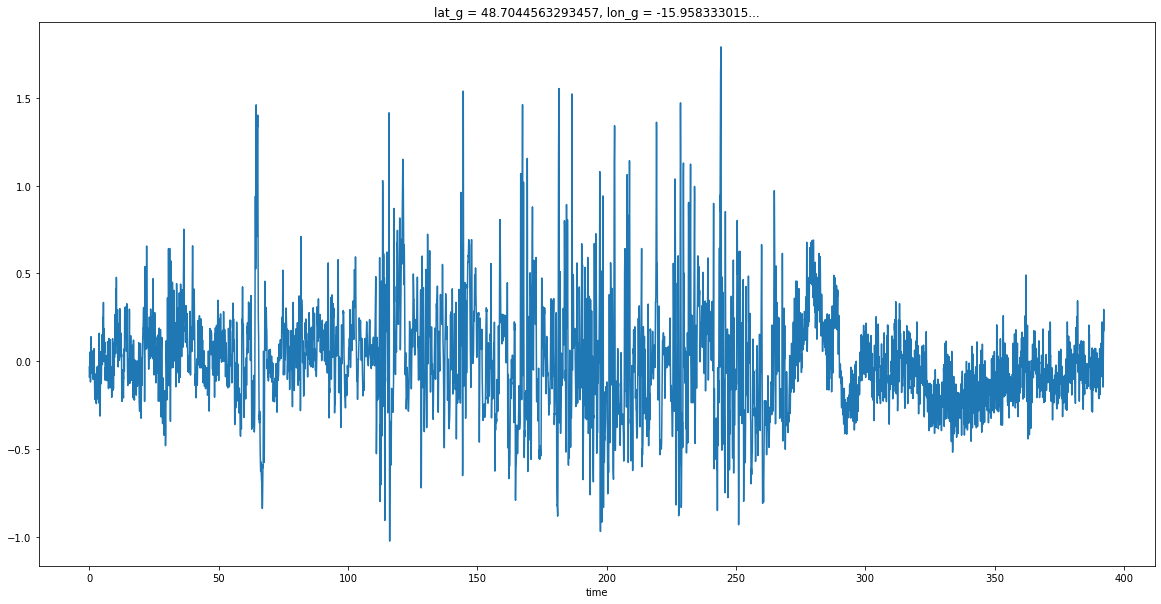

In [12]:
fig = plt.figure(figsize=(20,10))
zeta_f.isel(lat_g=100, lon_g=100,depth=1).plot()

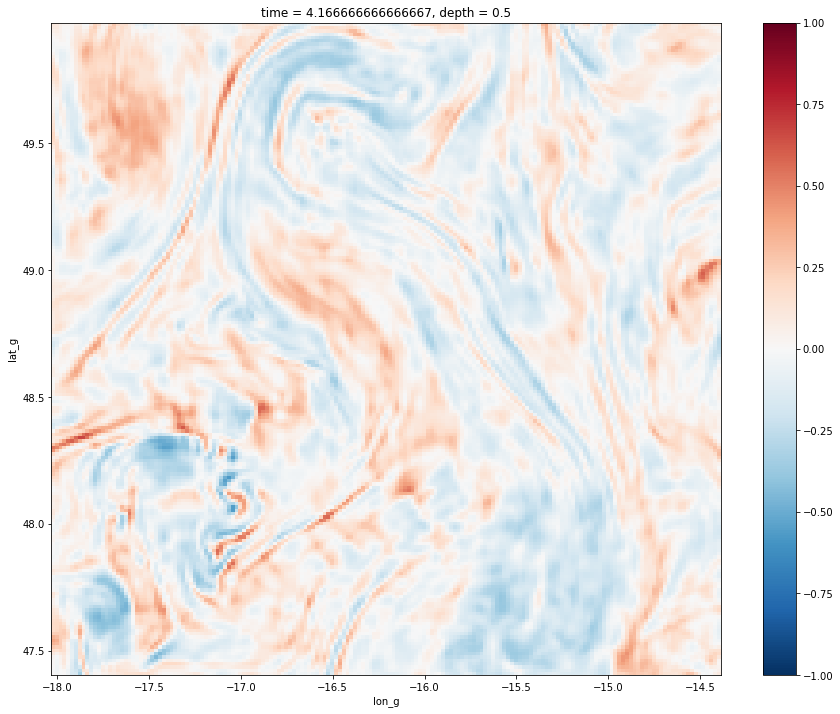

In [13]:
fig = plt.figure(figsize=(15,12))

zeta_f.isel(lat_g=slice(1,-1),lon_g=slice(1,-1),time=100,depth=0).plot(x='lon_g', y='lat_g', vmin=-1, vmax=1, cmap='RdBu_r')

## 2.2 KE

In [14]:
KE = (gridx.interp(ds['U']**2,'X') + gridx.interp(ds['V']**2,'Y'))/2 # KE
KE

<xarray.DataArray (time: 9415, depth: 52, lat: 201, lon: 177)>
dask.array<truediv, shape=(9415, 52, 201, 177), dtype=float32, chunksize=(1883, 1, 19, 16), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36

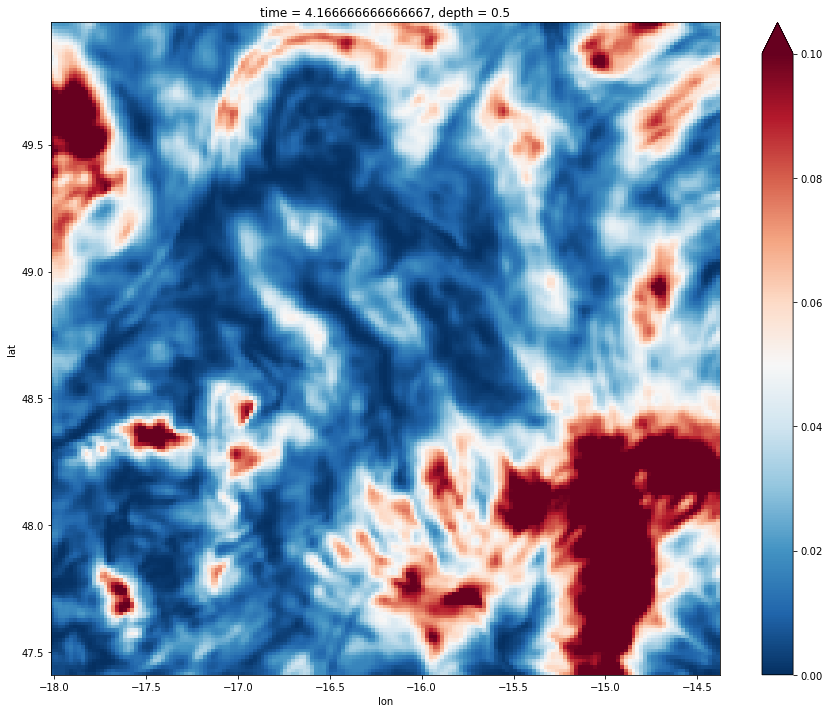

In [15]:
fig = plt.figure(figsize=(15,12))

KE.isel(lat=slice(1,-1),lon=slice(1,-1),time=100,depth=0).plot(x='lon', y='lat', vmin=0, vmax=0.1, cmap='RdBu_r')

## 2.4 lateral gradient

In [16]:
db_dx = gridx.diff(ds['Buoy'],'X')/ds.dxC     # db/dx
db_dx_ij = gridx.interp(db_dx,'X')
db_dy = gridx.diff(ds['Buoy'],'Y')/ds.dyC     # db/dy
db_dy_ij = gridx.interp(db_dy,'Y')

lateral_buoyancy_gradient = np.sqrt(db_dx_ij*db_dx_ij + db_dy_ij*db_dy_ij)
print(lateral_buoyancy_gradient)

<xarray.DataArray (time: 9415, depth: 52, lat: 201, lon: 177)>
dask.array<sqrt, shape=(9415, 52, 201, 177), dtype=float32, chunksize=(1883, 1, 18, 15), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36


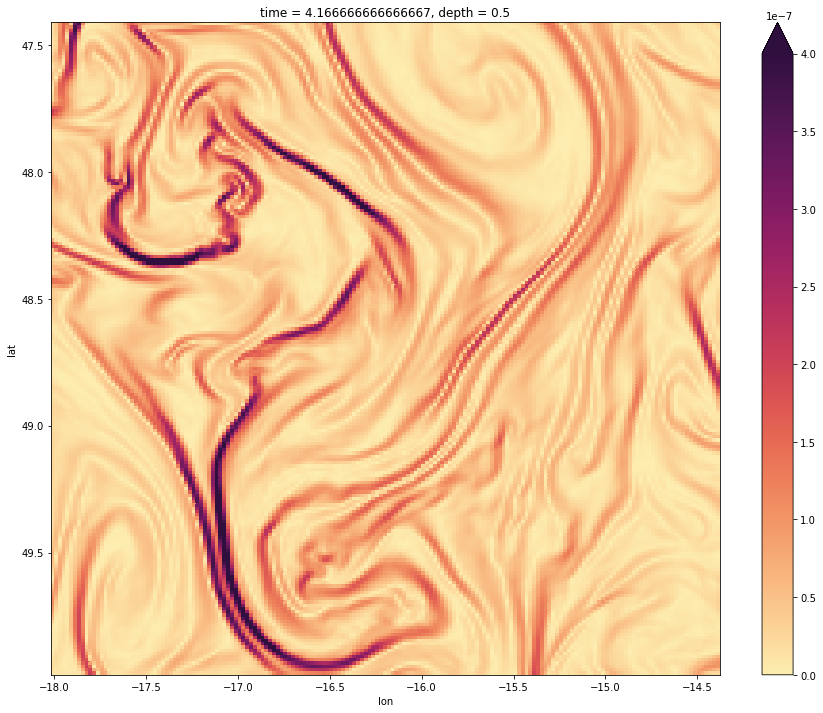

In [17]:
fig = plt.figure(figsize=(15,12))
lateral_buoyancy_gradient.isel(lat=slice(1,-1),lon=slice(1,-1),time=100,depth=0).plot(x='lon', y='lat', vmin=0, vmax=4e-7,cmap=cm.matter, yincrease=False)

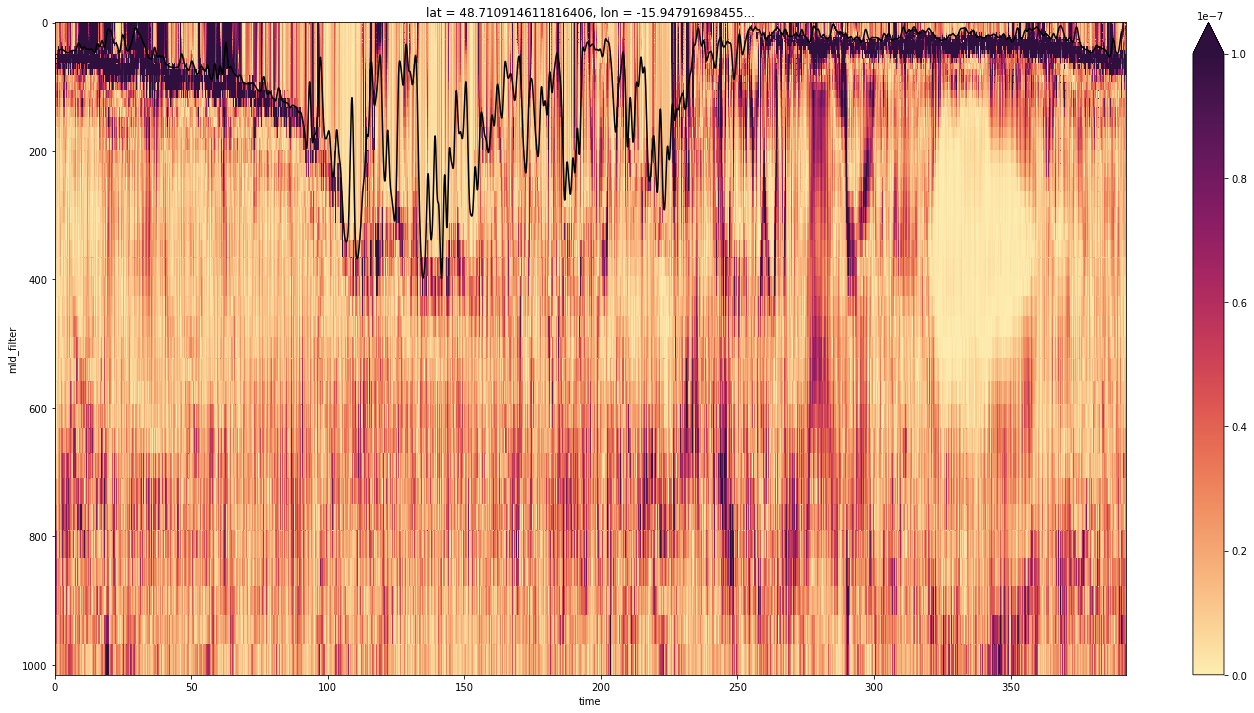

In [18]:
fig = plt.figure(figsize=(24,12))
lateral_buoyancy_gradient.isel(lat=100,lon=100).plot(x='time', y='depth',vmin=0,vmax=1e-7,cmap=cm.matter, yincrease=False)
ds.mld_filter.isel(lat=100,lon=100).plot(x='time',color='black', yincrease=False)

## 2.5 PV

In [19]:
zeta = (gridx.diff(ds.dyC*ds['V'],'X') - gridx.diff(ds.dxC * ds['U'],'Y'))/ds.rAz
zeta_i =  gridx.interp(zeta,'X')
zeta_ij =  gridx.interp(zeta_i,'Y')
zeta_ij

<xarray.DataArray 'mul-393a04cfd8341c51206cfe01c7917596' (lat: 201, lon: 177, time: 9415, depth: 52)>
dask.array<mul, shape=(201, 177, 9415, 52), dtype=float32, chunksize=(18, 15, 1883, 1), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3

In [20]:
db_dz_left = -1*gridx.diff(ds.Buoy, 'Z', boundary='fill', fill_value=np.nan) / ds.dzc  #### -1* is necessary to make the sign correct ####
db_dz = gridx.interp(db_dz_left,'Z', boundary='fill')
db_dz = db_dz.astype(np.float32)
print(db_dz)

<xarray.DataArray 'mul-efba19c9616ee4c287ffa4003c5260d0' (time: 9415, depth: 52, lat: 201, lon: 177)>
dask.array<astype, shape=(9415, 52, 201, 177), dtype=float32, chunksize=(1883, 1, 20, 17), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36


In [22]:
PV = (f_ij + zeta_ij)*db_dz - (db_dx_ij**2 + db_dy_ij**2)/f_ij
chunks = {'time': 1883, 'lat': 20, 'lon': 17, 'depth':1}
PV = PV.chunk(chunks)
PV

<xarray.DataArray (lat: 201, lon: 177, time: 9415, depth: 52)>
dask.array<rechunk-merge, shape=(201, 177, 9415, 52), dtype=float32, chunksize=(20, 17, 1883, 1), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3

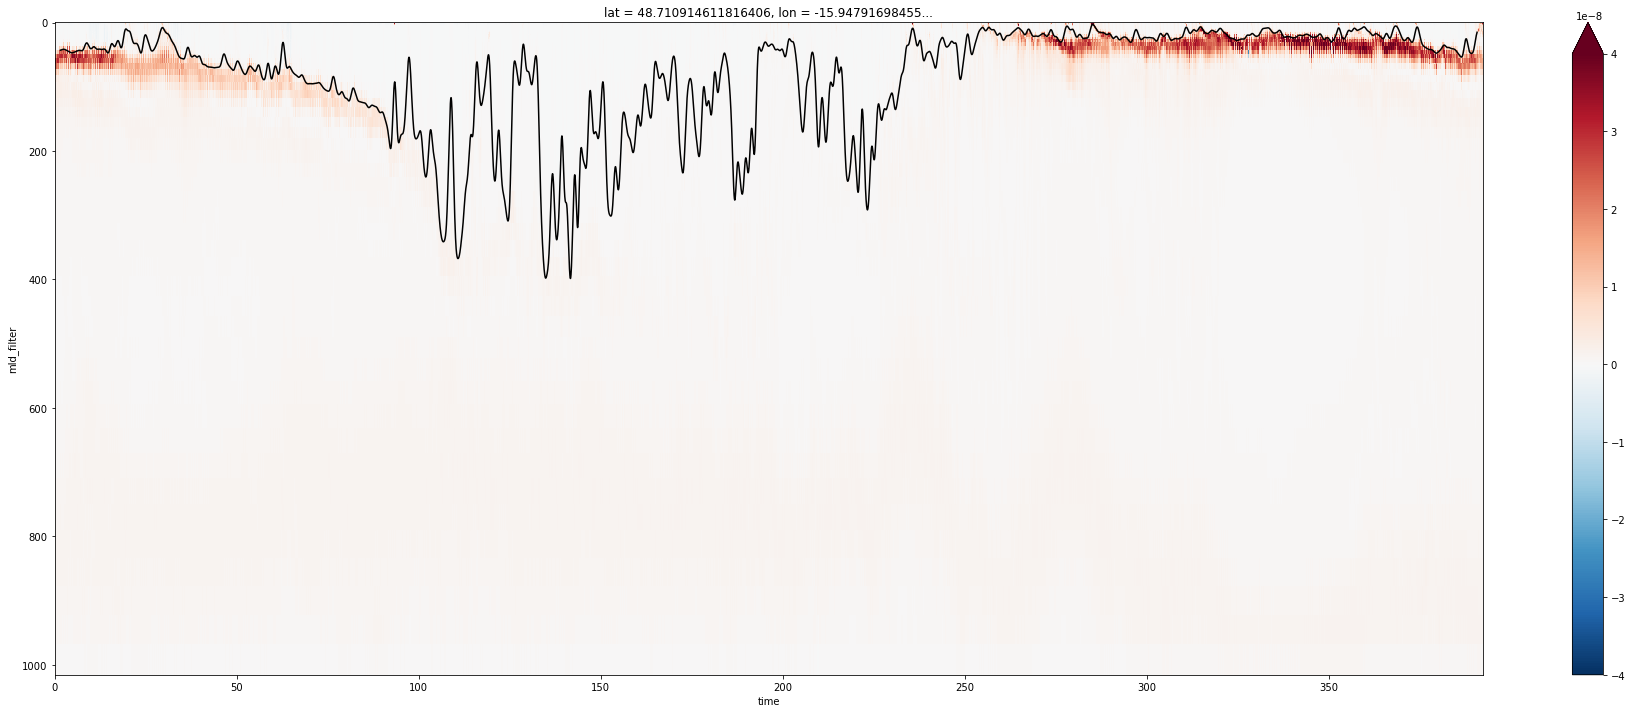

In [23]:
fig = plt.figure(figsize=(32,12))
PV.isel(lat=100,lon=100).plot(x='time', y='depth',vmin=-4e-8,vmax=4e-8,cmap='RdBu_r', yincrease=False)
ds.mld_filter.isel(lat=100,lon=100).plot(x='time',color='black', yincrease=False)

## 2.6 Richardson number

In [24]:
db_dz_left = -1*gridx.diff(ds.Buoy, 'Z', boundary='fill', fill_value=np.nan) / ds.dzc  #### -1* is necessary to make the sign correct ####
db_dz = gridx.interp(db_dz_left,'Z', boundary='fill')
db_dz = db_dz.astype(np.float32)
print(db_dz)

<xarray.DataArray 'mul-efba19c9616ee4c287ffa4003c5260d0' (time: 9415, depth: 52, lat: 201, lon: 177)>
dask.array<astype, shape=(9415, 52, 201, 177), dtype=float32, chunksize=(1883, 1, 20, 17), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36


In [25]:
dU_dz_left = -1*gridx.diff(ds.U, 'Z', boundary='fill', fill_value=np.nan) / ds.dzc
dU_dz_1 = gridx.interp(dU_dz_left,'Z', boundary='fill')
dU_dz = gridx.interp(dU_dz_1,'X')
dU_dz = dU_dz.astype(np.float32)
print(dU_dz)

<xarray.DataArray 'mul-5efd925a4727a9413d285f42ba8601be' (time: 9415, depth: 52, lat: 201, lon: 177)>
dask.array<astype, shape=(9415, 52, 201, 177), dtype=float32, chunksize=(1883, 1, 20, 16), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36


In [26]:
dV_dz_left = -1*gridx.diff(ds.V, 'Z', boundary='fill', fill_value=np.nan) / ds.dzc
dV_dz_1 = gridx.interp(dV_dz_left,'Z', boundary='fill')
dV_dz = gridx.interp(dV_dz_1,'Y')
dV_dz = dV_dz.astype(np.float32)
print(dV_dz)

<xarray.DataArray 'mul-769f0d3f824ac21dfffbe37163dcb7e0' (time: 9415, depth: 52, lat: 201, lon: 177)>
dask.array<astype, shape=(9415, 52, 201, 177), dtype=float32, chunksize=(1883, 1, 19, 17), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36


In [27]:
Ri = db_dz/(dU_dz**2 + dV_dz**2)
Ri

<xarray.DataArray (time: 9415, depth: 52, lat: 201, lon: 177)>
dask.array<truediv, shape=(9415, 52, 201, 177), dtype=float32, chunksize=(1883, 1, 19, 16), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36

In [28]:
chunks = {'time': 1883, 'lat': 20, 'lon': 17, 'depth':1}
Ri = Ri.chunk(chunks)
Ri = np.real(Ri).rename('Ri')
print(Ri)

<xarray.DataArray 'Ri' (time: 9415, depth: 52, lat: 201, lon: 177)>
dask.array<real, shape=(9415, 52, 201, 177), dtype=float32, chunksize=(1883, 1, 20, 17), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36


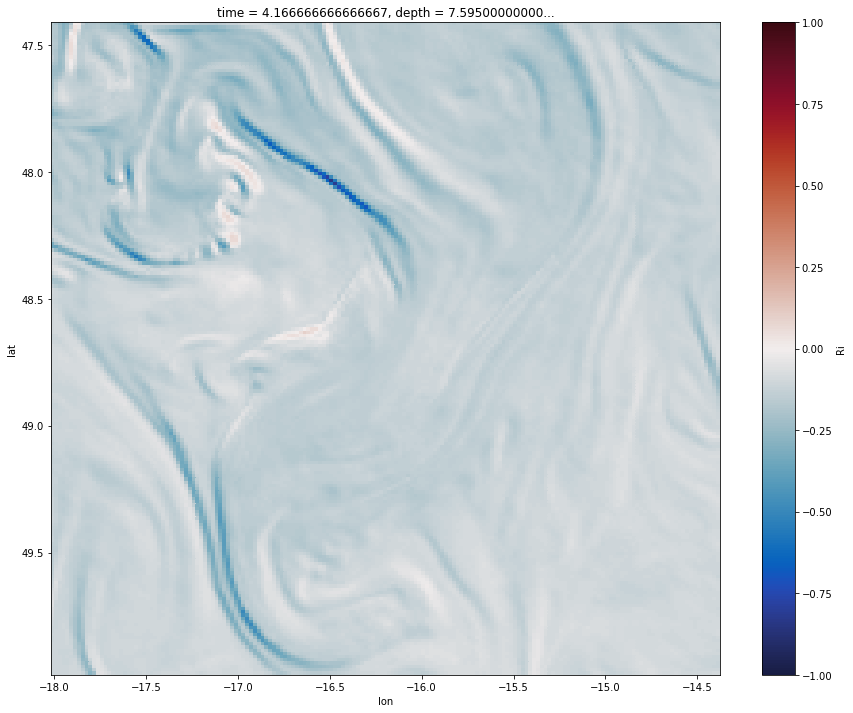

In [29]:
fig = plt.figure(figsize=(15,12))
Ri.isel(lat=slice(1,-1),lon=slice(1,-1),time=100,depth=5).plot(x='lon', y='lat', vmin=-1, vmax=1,cmap=cm.balance, yincrease=False)

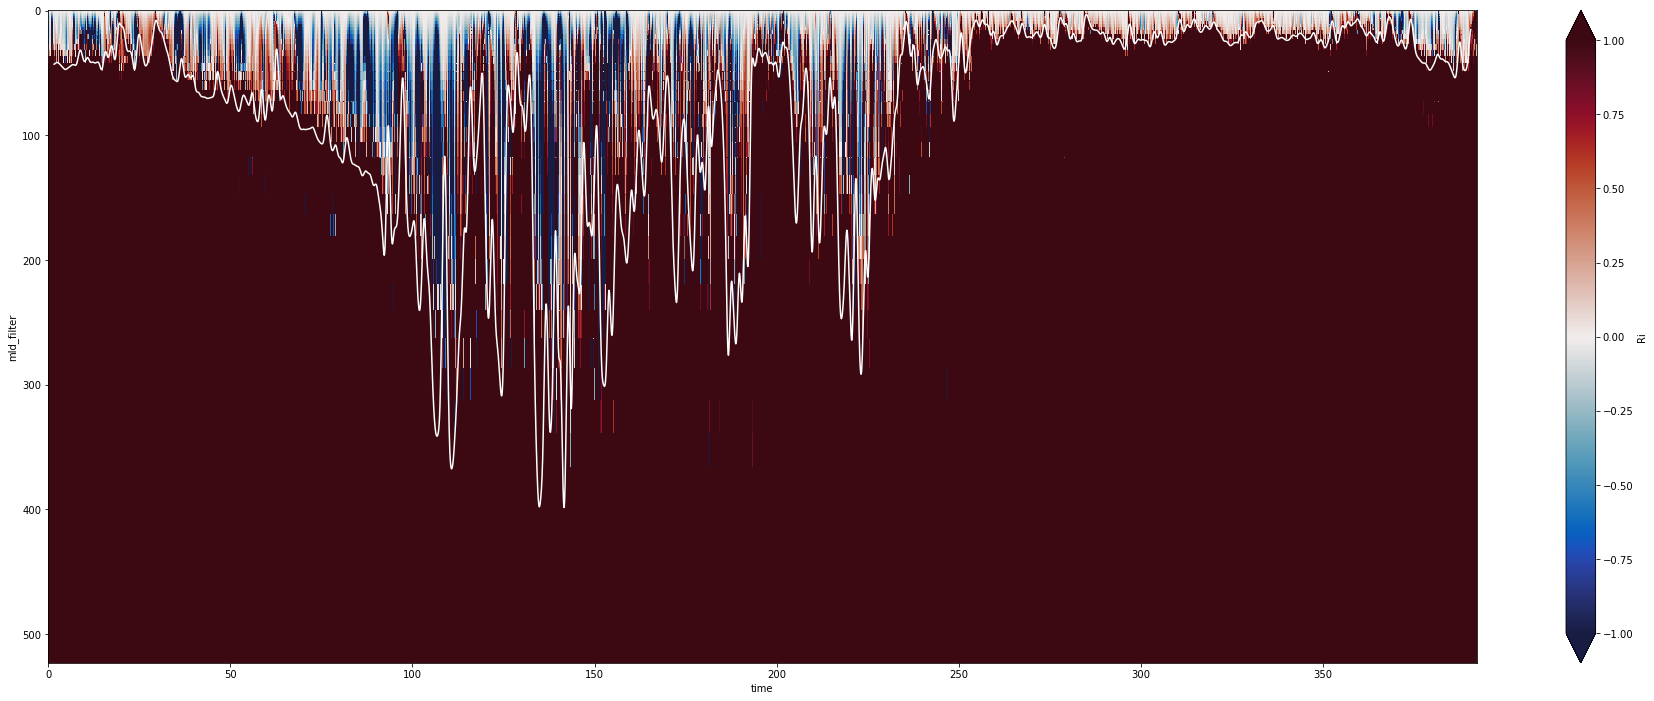

In [30]:
fig = plt.figure(figsize=(32,12))
Ri.isel(lat=100,lon=100,depth=slice(0,40)).plot(x='time', y='depth', cmap=cm.balance, vmin=-1, vmax=1, yincrease=False)
ds_MLD.mld_filter.isel(lat=100,lon=100).plot(x='time',color='white', yincrease=False)

## 2.7 Frontogenesis function

In [31]:
db_dx = gridx.diff(ds['Buoy'],'X')/ds.dxC     # db/dx
db_dx_ij = gridx.interp(db_dx,'X')
db_dx_ij

<xarray.DataArray 'mul-c4c770b8a799ee70c4d9f115598a349d' (time: 9415, depth: 52, lat: 201, lon: 177)>
dask.array<mul, shape=(9415, 52, 201, 177), dtype=float32, chunksize=(1883, 1, 20, 15), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36

In [32]:
db_dy = gridx.diff(ds['Buoy'],'Y')/ds.dyC     # db/dy
db_dy_ij = gridx.interp(db_dy,'Y')
db_dy_ij

<xarray.DataArray 'mul-9e2044187d2771b156999c0770c49ee9' (time: 9415, depth: 52, lat: 201, lon: 177)>
dask.array<mul, shape=(9415, 52, 201, 177), dtype=float32, chunksize=(1883, 1, 18, 17), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36

In [33]:
du_dx_ij = gridx.diff(ds['U'], 'X')/gridx.interp(ds.dxG, 'Y')
du_dx_ij

<xarray.DataArray (time: 9415, depth: 52, lat: 201, lon: 177)>
dask.array<truediv, shape=(9415, 52, 201, 177), dtype=float32, chunksize=(1883, 1, 20, 16), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36

In [34]:
dU_dy_1 = gridx.diff(ds['U'], 'Y')/gridx.interp(ds.dyC, 'X')
dU_dy_2 = gridx.interp(dU_dy_1, 'X')
du_dy_ij = gridx.interp(dU_dy_2, 'Y')
du_dy_ij

<xarray.DataArray 'mul-04c8366d3bf17139b6bea7bfc5fe5f7b' (time: 9415, depth: 52, lat: 201, lon: 177)>
dask.array<mul, shape=(9415, 52, 201, 177), dtype=float32, chunksize=(1883, 1, 18, 16), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36

In [35]:
dV_dx_1 = gridx.diff(ds['V'], 'X')/gridx.interp(ds.dxC, 'Y')
dV_dx_2 = gridx.interp(dV_dx_1, 'X')
dv_dx_ij = gridx.interp(dV_dx_2, 'Y')
dv_dx_ij

<xarray.DataArray 'mul-20d93ea941e4099cdf5815c40ac3565c' (time: 9415, depth: 52, lat: 201, lon: 177)>
dask.array<mul, shape=(9415, 52, 201, 177), dtype=float32, chunksize=(1883, 1, 19, 15), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36

In [36]:
dv_dy_ij = gridx.diff(ds['V'], 'Y')/gridx.interp(ds.dyG, 'X')
dv_dy_ij

<xarray.DataArray (time: 9415, depth: 52, lat: 201, lon: 177)>
dask.array<truediv, shape=(9415, 52, 201, 177), dtype=float32, chunksize=(1883, 1, 19, 17), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36

In [37]:
Fs = -(du_dx_ij*db_dx_ij*db_dx_ij + dv_dx_ij*db_dx_ij*db_dy_ij + du_dy_ij*db_dx_ij*db_dy_ij + dv_dy_ij*db_dy_ij*db_dy_ij)
chunks = {'time': 1883, 'lat': 20, 'lon': 17, 'depth':1}
Fs = Fs.chunk(chunks)
Fs

<xarray.DataArray (time: 9415, depth: 52, lat: 201, lon: 177)>
dask.array<rechunk-merge, shape=(9415, 52, 201, 177), dtype=float32, chunksize=(1883, 1, 20, 17), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36

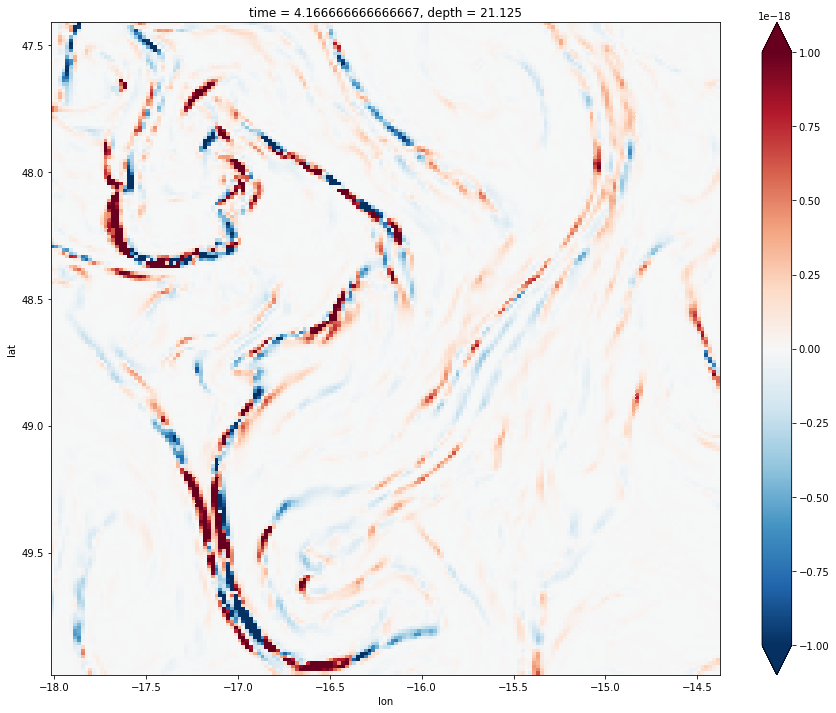

In [38]:
fig = plt.figure(figsize=(15,12))
Fs.isel(lat=slice(1,-1),lon=slice(1,-1),time=100,depth=10).plot(x='lon', y='lat', vmin=-1e-18, vmax=1e-18,cmap='RdBu_r', yincrease=False)

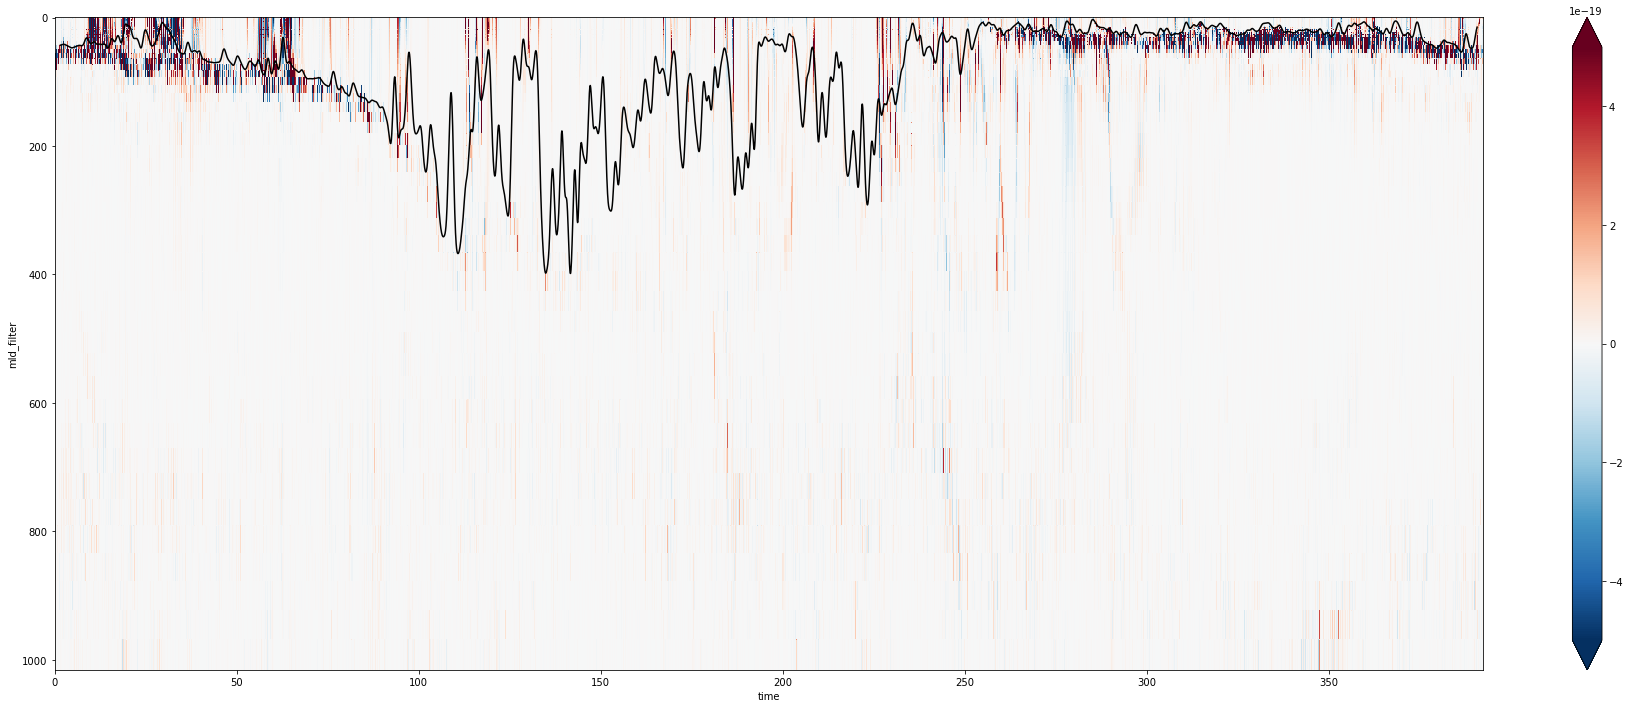

In [39]:
fig = plt.figure(figsize=(32,12))
Fs.isel(lat=100,lon=100).plot(x='time', y='depth', vmin=-5e-19, vmax=5e-19, cmap='RdBu_r', yincrease=False)
ds_MLD.mld_filter.isel(lat=100,lon=100).plot(x='time',color='black', yincrease=False)

In [41]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/utils.py", line 666, in log_errors
    yield
  File "/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/client.py", line 1276, in _close
    await gen.with_timeout(timedelta(seconds=2), list(coroutines))
concurrent.futures._base.CancelledError
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/utils.py", line 666, in log_errors
    yield
  File "/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/client.py", line 1005, in _reconnect
    await self._close()
  File "/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/client.py", line 1